In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pickle
import gc
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import resnet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split

from xgboost import XGBClassifier

from PIL import Image, UnidentifiedImageError, ImageEnhance

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Path

# path = os.getcwd().replace("notebooks", "") ## Local path directory and cookie cutter ds templete
gcolb_path = {
    "glioma": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_glioma",
    "meningioma": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_menin",
    "tumor": "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/external/BrainCancer/brain_tumor"
}

In [4]:
glioma = {
    'category_name': 'glioma',
    # 'load_command': [fr'{path + r"data\external\BrainCancer\brain_glioma"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_glioma")] Local command
    'load_command': [f"{gcolb_path['glioma']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['glioma'])]
}

meningioma = {
    'category_name': 'meningioma',
    # 'load_command': [fr'{path + r"data\external\BrainCancer\brain_menin"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_menin")] Local command
    'load_command': [f"{gcolb_path['meningioma']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['meningioma'])]
}

tumor = {
    'category_name': 'tumor',
    # 'load_command': [fr'{path + r"data\external\BrainCancer\brain_tumor"}\{i}' for i in os.listdir(path + r"data\external\BrainCancer\brain_tumor")] Local command
    'load_command': [f"{gcolb_path['tumor']}" + "/" + f'{i}' for i in os.listdir(gcolb_path['tumor'])]
}

categories = [glioma, meningioma, tumor]

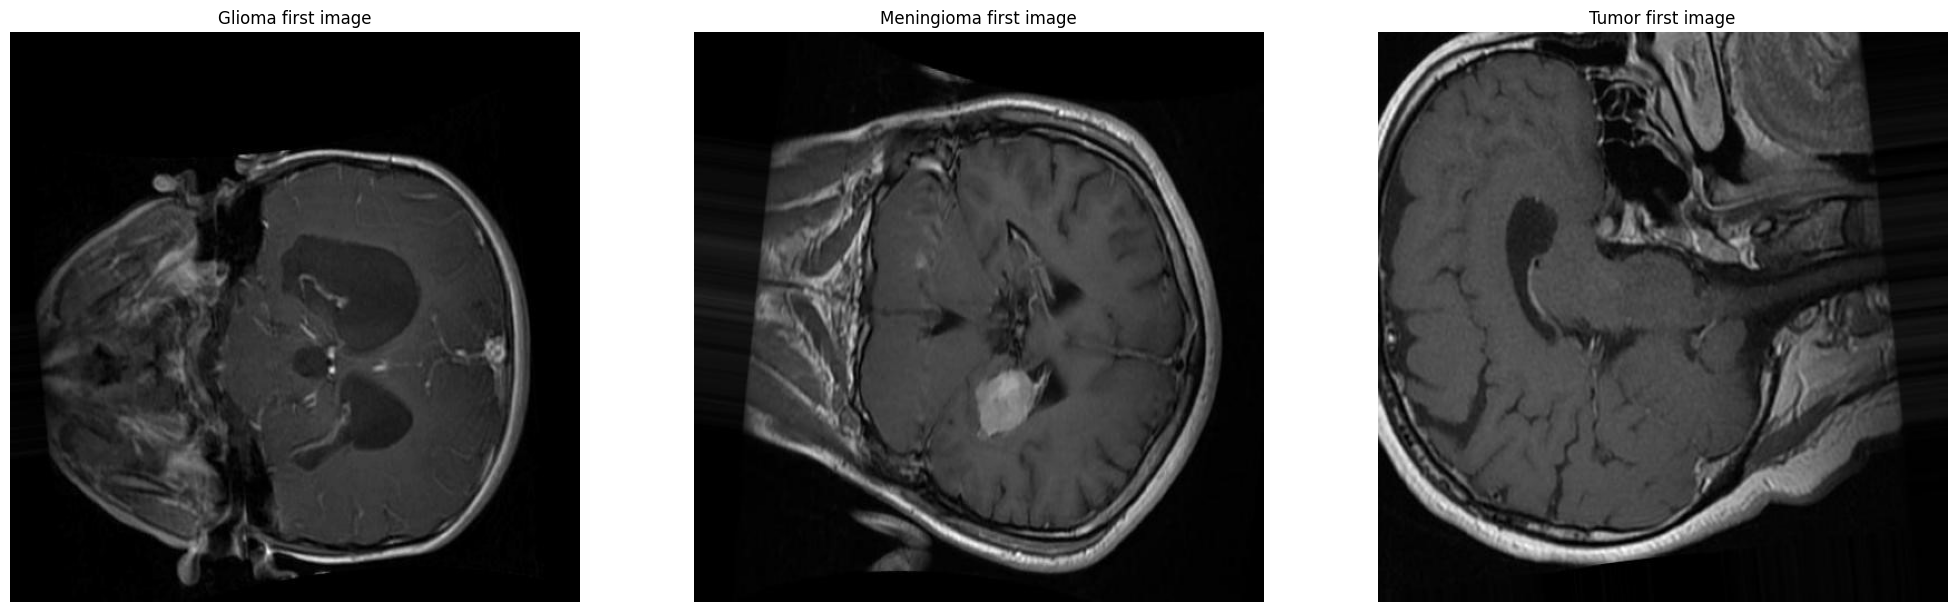



Size of the image
Category: glioma
(512, 512)


Size of the image
Category: meningioma
(512, 512)


Size of the image
Category: tumor
(512, 512)


In [5]:
img1 = Image.open(f"{glioma['load_command'][0]}")
img2 = Image.open(f"{meningioma['load_command'][0]}")
img3 = Image.open(f"{tumor['load_command'][0]}")

plt.figure(figsize=(25, 10))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow([img1, img2, img3][i])
    plt.title(["Glioma first image", "Meningioma first image", "Tumor first image"][i])
    plt.axis("off")
plt.show()

for size,name in zip([img1.size, img2.size, img3.size],categories):
    print('\n')
    print(f"Size of the image\nCategory: {name['category_name']}")
    print(size)

In [ ]:
def load_images(img_vector, img_shape=tuple):
  X,y = [],[]

  for vector in img_vector:
    total_images = len(vector['load_command'])

    progress_bar = tqdm(total=total_images, desc="Loading images", unit="img")

    for images in vector['load_command']:
      img = Image.open(images)
      img.resize(img_shape)
      img = np.asarray(img)
      X.append(img)
      y.append(vector['category_name'])
      progress_bar.update(1)

    progress_bar.close()

  return X, y

In [7]:
def save_variables(variables, filename):
  with open(filename, 'wb') as file:
      pickle.dump(variables, file)
  print(f"Variables saved to {filename}.")

In [ ]:
#Inceoption_V3 load pipeline
# X, y = load_images(categories, (299, 299)) #Inception_V3 input
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
# X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

In [ ]:
# save_variables = {
#     "X_train": X_train,
#     "X_test": X_test,
#     "X_val": X_val,
#     "y_train": y_train,
#     "y_test": y_test,
#     "y_val": y_val,
# }

In [ ]:
# save_variables(save_variables, "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/processed/variables.pkl")


In [8]:
def load_variables(filename):
  with open(filename, 'rb') as file:
      variables = pickle.load(file)
  print(f"Variables loaded from {filename}.")
  return variables

In [9]:
loaded_variables = load_variables("/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/processed/variables.pkl")

Variables loaded from /content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/processed/variables.pkl.


In [10]:
X_train = np.asarray(loaded_variables["X_train"])
X_test = np.asarray(loaded_variables["X_test"])
X_val = np.asarray(loaded_variables["X_val"])
y_train = loaded_variables["y_train"]
y_test = loaded_variables["y_test"]
y_val = loaded_variables["y_val"]

category_dict = {
    "glioma": 0,
    "meningioma": 1,
    "tumor": 2
}

y_train = [category_dict[i] for i in y_train]
y_test = [category_dict[i] for i in y_test]
y_val = [category_dict[i] for i in y_val]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

In [ ]:
model = Sequential()
model.add(RandomFlip("horizontal_and_vertical"))
model.add(RandomZoom(
    height_factor = (-0.5,0.5),
    width_factor = (-0.5,0.5),
))
model.add(RandomRotation(0.5))
model.add(resnet50.ResNet50(include_top = False, weights = "imagenet", input_shape = (224,224,3)))
model.add(Conv2D(128, (1,1)))
model.add(Conv2D(256, (1,1)))
model.add(Conv2D(512, (1,1)))
model.add(MaxPooling2D((2,2), padding = "same"))
model.add(SpatialDropout2D(0.4))
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(512, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(128, activation = "relu"))
model.add(Dropout(0.4))
model.add(Dense(64, activation = "relu"))
model.add(Dense(32, activation = "relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())
model.add(Dense(3, activation = "softmax"))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [12]:
callbacks = [
    EarlyStopping(monitor = 'val_loss', patience = 8, restore_best_weights = True),
    ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 3, min_lr = 0.0001)
]

In [13]:
model.compile(loss = keras.losses.CategoricalCrossentropy(), optimizer = keras.optimizers.Adadelta(learning_rate=0.5), metrics = ["accuracy", "categorical_accuracy"])
history_inception = model.fit(X_train, y_train, epochs = 100 , batch_size = 50, validation_data = (X_val, y_val), callbacks = callbacks)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 198s 835ms/step - accuracy: 0.6345 - categorical_accuracy: 0.6345 - loss: 0.8689 - val_accuracy: 0.9337 - val_categorical_accuracy: 0.9337 - val_loss: 0.2272 - learning_rate: 0.5000
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 202s 866ms/step - accuracy: 0.9053 - categorical_accuracy: 0.9053 - loss: 0.3074 - val_accuracy: 0.8950 - val_categorical_accuracy: 0.8950 - val_loss: 0.4933 - learning_rate: 0.5000
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 202s 867ms/step - accuracy: 0.9371 - categorical_accuracy: 0.9371 - loss: 0.2094 - val_accuracy: 0.9433 - val_categorical_accuracy: 0.9433 - val_loss: 0.1519 - learning_rate: 0.5000
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 202s 866ms/step - accuracy: 0.9424 - categorical_accuracy: 0.9424 - loss: 0.1937 - val_accuracy: 0.8323 - val_categorical_accuracy: 0.8323 - val_loss: 0.8072 - learning_rate: 0.5000
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 156s 865ms/step - accuracy: 0.9544 - categorical_accuracy: 0.9544 -

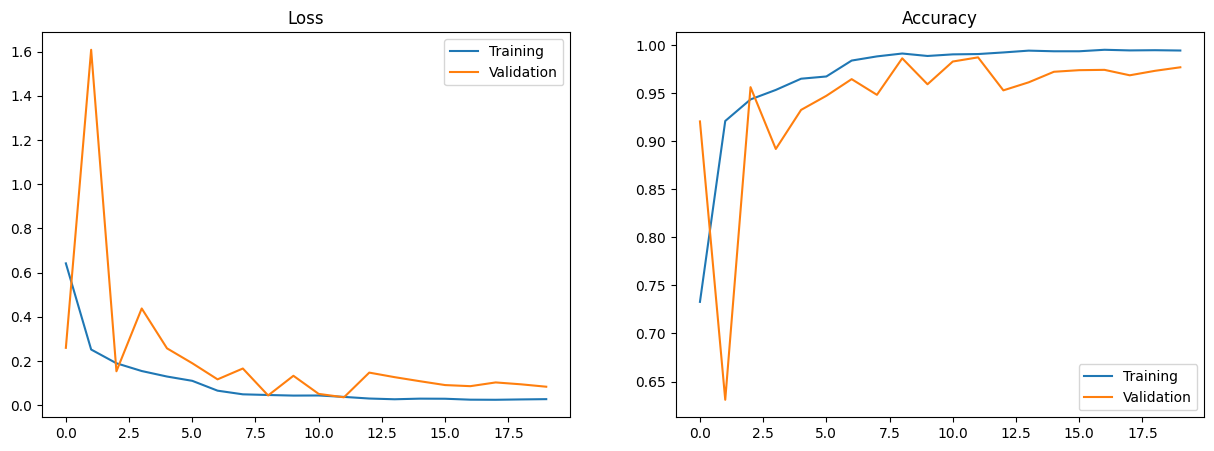

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))
sns.lineplot(ax = ax[0], data = history_inception.history["loss"], label = "Training")
sns.lineplot(ax = ax[0], data = history_inception.history["val_loss"], label = "Validation")
ax[0].set_title("Loss")
sns.lineplot(ax = ax[1], data = history_inception.history["accuracy"], label = "Training")
sns.lineplot(ax = ax[1], data = history_inception.history["val_accuracy"], label = "Validation")
ax[1].set_title("Accuracy")
plt.show()

In [14]:
save_variables = {
    "X_train": X_train,
    "X_test": X_test,
    "X_val": X_val,
    "y_train": y_train,
    "y_test": y_test,
    "y_val": y_val,
}

save_model = {
    "model": model,
    "history": history_inception
}

In [15]:
def save_variables(variables, filename):
  with open(filename, 'wb') as file:
      pickle.dump(variables, file)
  print(f"Variables saved to {filename}.")

In [16]:
# save_variables(save_variables, "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/data/processed/variables.pkl")
save_variables(save_model, "/content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/models/resnet_model.pkl")

Variables saved to /content/drive/MyDrive/UNDB_INTELIGÊNCIA ARTIFICIAL_PBL2/models/resnet_model.pkl.
